# 5. Prescriptive Analytics

## 5.1 Fuzzy Rule Based Clustering

In [38]:
# Standard libraries
import os  # For interacting with the operating system (file paths, directories, etc.)
import numpy as np  # For numerical operations, arrays, and random number generation

# Third-party libraries
import pandas as pd  # For data manipulation, analysis, and working with DataFrames
import skfuzzy as fuzz  # For fuzzy logic operations
import skfuzzy.control as ctrl  # For fuzzy control system operations
import matplotlib.pyplot as plt  # For creating visualizations (plots)
import seaborn as sns  # For statistical data visualization based on Matplotlib

# Suppress warnings to avoid cluttering the output
import warnings
warnings.filterwarnings('ignore')


In [39]:
# Define file paths for datasets
X_test_path = os.path.join("feature_selection", "X_test_selected.csv")  # Path to the feature-selected test data
Churn_data_path = os.path.join("churn_data", "churn_results.csv")  # Path to the churn results data
cid_path = os.path.join("split_data", "customer_test.csv")  # Path to customer test data (customer IDs)

# Try to load datasets while handling potential errors
try:
    # Load datasets without setting the first column as the index
    df = pd.read_csv(X_test_path)  # Load feature selection test data
    churn_df = pd.read_csv(Churn_data_path)  # Load churn results data
    customer_test = pd.read_csv(cid_path)  # Load customer test data (without index column)

    print("Datasets loaded successfully!")  # Success message

# Catch specific errors related to file loading or parsing
except FileNotFoundError as e:  # Raised when a file is not found
    print(f"Error loading files: {e}")

except pd.errors.ParserError as e:  # Raised if there is an issue parsing the CSV files
    print(f"Error parsing CSV files: {e}")

# Catch all other unexpected errors
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Datasets loaded successfully!


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   total_charges                           1409 non-null   float64
 1   tenure                                  1409 non-null   float64
 2   payment_method_Electronic check         1409 non-null   float64
 3   monthly_charges                         1409 non-null   float64
 4   contract_Two year                       1409 non-null   float64
 5   internet_service_Fiber optic            1409 non-null   float64
 6   internet_service_No                     1409 non-null   float64
 7   payment_method_Credit card (automatic)  1409 non-null   float64
 8   dependents                              1409 non-null   int64  
 9   contract_One year                       1409 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 110.2 KB


In [41]:
# Ensure customer_test is a 1D Series instead of a 2D DataFrame
if customer_test.shape[1] == 1:  # Check if customer_test has only one column
    customer_test = customer_test.squeeze()  # Convert DataFrame to Series

# Add the 'customer_id' back to the result dataframe 'df'
df['customer_id'] = customer_test.values  # Assign the values of 'customer_test' to 'customer_id'

# Reorder columns to place 'customer_id' at the beginning of the DataFrame
column_order = ['customer_id'] + [col for col in df.columns if col != 'customer_id']
df = df[column_order]  # Rearrange columns based on the new order

# Print the first few rows of the updated DataFrame to inspect the changes
print(df.head())  # Display the updated DataFrame


  customer_id  total_charges    tenure  payment_method_Electronic check  \
0  4376-KFVRS       0.990743  1.000000                              0.0   
1  2754-SDJRD       0.104318  0.111111                              0.0   
2  9917-KWRBE       0.374321  0.569444                              0.0   
3  0365-GXEZS       0.170006  0.250000                              1.0   
4  9385-NXKDA       0.691871  1.000000                              0.0   

   monthly_charges  contract_Two year  internet_service_Fiber optic  \
0         0.954046                1.0                           1.0   
1         0.815185                0.0                           1.0   
2         0.597403                0.0                           0.0   
3         0.595904                0.0                           1.0   
4         0.640360                1.0                           0.0   

   internet_service_No  payment_method_Credit card (automatic)  dependents  \
0                  0.0                      

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 11 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   customer_id                             1409 non-null   object 
 1   total_charges                           1409 non-null   float64
 2   tenure                                  1409 non-null   float64
 3   payment_method_Electronic check         1409 non-null   float64
 4   monthly_charges                         1409 non-null   float64
 5   contract_Two year                       1409 non-null   float64
 6   internet_service_Fiber optic            1409 non-null   float64
 7   internet_service_No                     1409 non-null   float64
 8   payment_method_Credit card (automatic)  1409 non-null   float64
 9   dependents                              1409 non-null   int64  
 10  contract_One year                       1409 non-null   floa

               total_charges                                                   \
                       count      mean       std       min      25%       50%   
Customer Type                                                                   
Low Engagement         214.0  0.011185  0.011343  0.000000  0.00281  0.006107   
Premium                190.0  0.771483  0.101833  0.603516  0.68485  0.759890   
Standard              1005.0  0.213500  0.169501  0.005933  0.07250  0.165819   

                                   monthly_charges            ...            \
                     75%       max           count      mean  ...       75%   
Customer Type                                                 ...             
Low Engagement  0.018303  0.047925           214.0  0.119748  ...  0.262430   
Premium         0.841202  1.000000           190.0  0.831747  ...  0.921360   
Standard        0.315001  0.644198          1005.0  0.469368  ...  0.675799   

                          tenure      

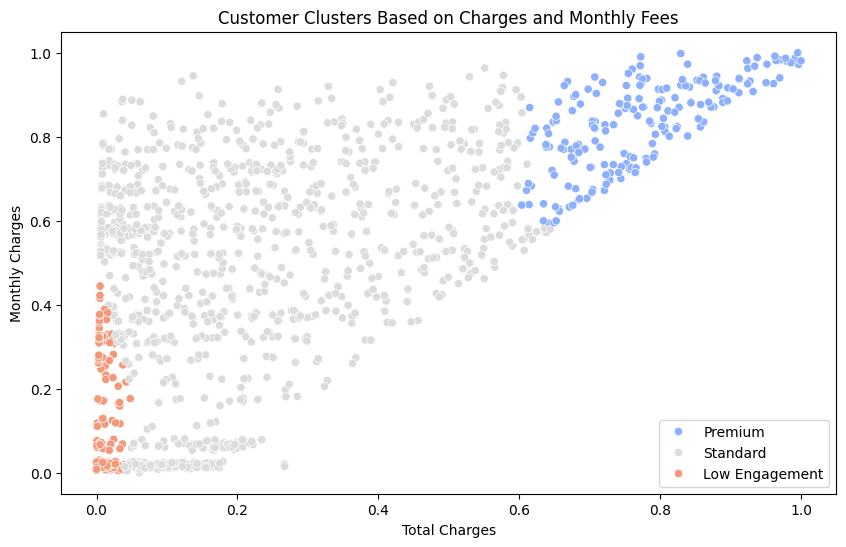

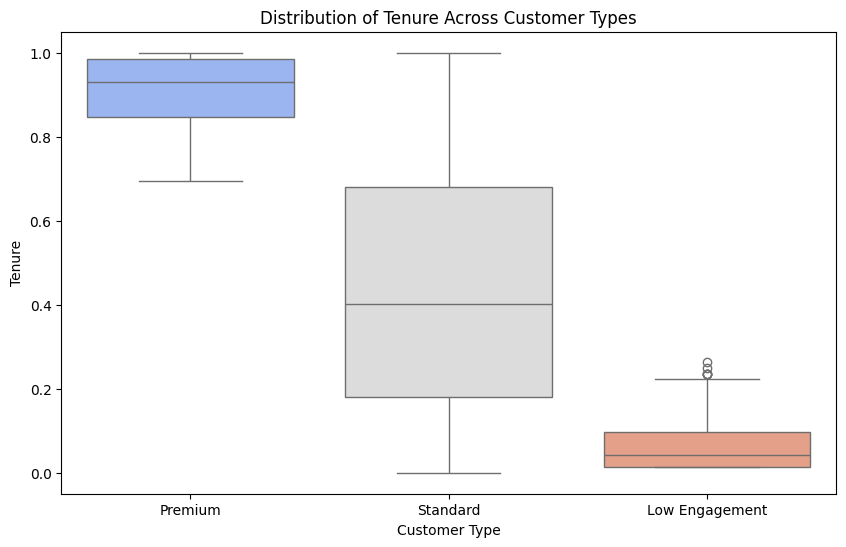

In [43]:
# How it works:
# 1. Data preparation:
# The data is first normalized and the relevant features are identified.

def normalize_column(column):
    return (column - column.min()) / (column.max() - column.min())

# Normalize dataset
df['total_charges'] = normalize_column(df['total_charges'])
df['monthly_charges'] = normalize_column(df['monthly_charges'])
df['tenure'] = normalize_column(df['tenure'])

# 2. Fuzzy set definition:
# Membership functions are defined for each feature, which determine the degree of membership of a data point in a particular fuzzy set.

total_charges = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'total_charges')
monthly_charges = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'monthly_charges')
tenure = ctrl.Antecedent(np.arange(0, 1.1, 0.01), 'tenure')
customer_type = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'customer_type', defuzzify_method='centroid')

# Membership Functions (Poor, Average, Good)
total_charges.automf(3)
monthly_charges.automf(3)
tenure.automf(3)
customer_type.automf(3)

# 3. Rule base creation:
# A set of fuzzy rules are formulated based on the desired cluster characteristics, specifying the relationships between feature values and cluster memberships.

rule1 = ctrl.Rule(total_charges['good'] & monthly_charges['good'] & tenure['good'], customer_type['good'])
rule2 = ctrl.Rule(total_charges['average'] & monthly_charges['average'] & tenure['average'], customer_type['average'])
rule3 = ctrl.Rule(total_charges['poor'] & monthly_charges['poor'] & tenure['poor'], customer_type['poor'])

# Add Default Rule (Fallback Case)
default_rule = ctrl.Rule(~(total_charges['good'] | total_charges['average'] | total_charges['poor']), customer_type['average'])

# 4. Clustering process:
# For each data point, the degree of membership in each cluster is calculated based on the fuzzy rules and membership functions.

# Control System
customer_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, default_rule])
customer_simulation = ctrl.ControlSystemSimulation(customer_ctrl)

# 5. Cluster assignment:
# Data points are assigned to clusters based on their highest membership degrees.

def classify_customers(df):
    # Store the original index to ensure the order is preserved
    original_index = df.index
    
    customer_types = []
    
    for i, row in df.iterrows():
        try:
            customer_simulation.input['total_charges'] = row['total_charges']
            customer_simulation.input['monthly_charges'] = row['monthly_charges']
            customer_simulation.input['tenure'] = row['tenure']
            customer_simulation.compute()
            
            output_value = customer_simulation.output['customer_type']
            if output_value < 0.3:
                customer_types.append('Low Engagement')
            elif output_value < 0.55:
                customer_types.append('Standard')
            else:
                customer_types.append('Premium')
        except Exception as e:
            customer_types.append(f'Error: {str(e)}')
    
    # Add the 'Customer Type' column without disturbing the index
    df['Customer Type'] = customer_types
    
    # Reassign the original index (this will not affect the order)
    df.index = original_index
    
    return df

# Apply function to actual DataFrame (df)
df_cluster = classify_customers(df)

# Statistical Description of Each Cluster
print(df_cluster.groupby('Customer Type')[['total_charges', 'monthly_charges', 'tenure']].describe())

# Visualizing Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_cluster, x='total_charges', y='monthly_charges', hue='Customer Type', palette='coolwarm')
plt.title('Customer Clusters Based on Charges and Monthly Fees')
plt.xlabel('Total Charges')
plt.ylabel('Monthly Charges')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=df_cluster, x='Customer Type', y='tenure', palette='coolwarm')
plt.title('Distribution of Tenure Across Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Tenure')
plt.show()


In [44]:
# Display the first few rows of the DataFrame to verify changes
df_cluster.head()

,customer_id,total_charges,tenure,payment_method_Electronic check,monthly_charges,contract_Two year,internet_service_Fiber optic,internet_service_No,payment_method_Credit card (automatic),dependents,contract_One year,Customer Type
0,4376-KFVRS,0.996638,1.000000,0.0,0.972095,1.0,1.0,0.0,1.0,1,0.0,Premium
1,2754-SDJRD,0.104949,0.111111,0.0,0.831050,0.0,1.0,0.0,1.0,0,0.0,Standard
2,9917-KWRBE,0.376556,0.569444,0.0,0.609843,0.0,0.0,0.0,1.0,1,1.0,Standard
3,0365-GXEZS,0.171027,0.250000,1.0,0.608321,0.0,1.0,0.0,0.0,0,0.0,Standard
4,9385-NXKDA,0.695992,1.000000,0.0,0.653475,1.0,0.0,0.0,1.0,0,0.0,Premium


In [45]:
# Display the first few rows of the DataFrame to verify changes
churn_df.head()

,Unnamed: 0,customer_id,total_charges,tenure,payment_method_Electronic check,monthly_charges,contract_Two year,internet_service_Fiber optic,internet_service_No,payment_method_Credit card (automatic),dependents,contract_One year,y_pred,Class_1_Probability
0,0,4376-KFVRS,0.990743,1.000000,0.0,0.954046,1.0,1.0,0.0,1.0,1,0.0,0,0.009585
1,1,2754-SDJRD,0.104318,0.111111,0.0,0.815185,0.0,1.0,0.0,1.0,0,0.0,1,0.948477
2,2,9917-KWRBE,0.374321,0.569444,0.0,0.597403,0.0,0.0,0.0,1.0,1,1.0,0,0.122242
3,3,0365-GXEZS,0.170006,0.250000,1.0,0.595904,0.0,1.0,0.0,0.0,0,0.0,1,0.938257
4,4,9385-NXKDA,0.691871,1.000000,0.0,0.640360,1.0,0.0,0.0,1.0,0,0.0,0,0.076077


In [46]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1409 entries, 0 to 1408
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              1409 non-null   int64  
 1   customer_id                             1409 non-null   object 
 2   total_charges                           1409 non-null   float64
 3   tenure                                  1409 non-null   float64
 4   payment_method_Electronic check         1409 non-null   float64
 5   monthly_charges                         1409 non-null   float64
 6   contract_Two year                       1409 non-null   float64
 7   internet_service_Fiber optic            1409 non-null   float64
 8   internet_service_No                     1409 non-null   float64
 9   payment_method_Credit card (automatic)  1409 non-null   float64
 10  dependents                              1409 non-null   int6

In [47]:
# Assuming both DataFrames have a 'customer_id' column for matching

# Merge the two DataFrames on 'customer_id' while keeping the original 'churn_df' index intact
churn_df = churn_df.merge(df[['customer_id', 'Customer Type']], on='customer_id', how='left')

# Rename the 'Customer Type' column to 'customer_type' for consistency
churn_df.rename(columns={'Customer Type': 'customer_type'}, inplace=True)

# Optional: Print the first few rows to verify the merge
print(churn_df.head())

# Save the updated churn_df to a new file if needed
# churn_df.to_csv('path_to_save.csv', index=False)


   Unnamed: 0 customer_id  total_charges    tenure  \
0           0  4376-KFVRS       0.990743  1.000000   
1           1  2754-SDJRD       0.104318  0.111111   
2           2  9917-KWRBE       0.374321  0.569444   
3           3  0365-GXEZS       0.170006  0.250000   
4           4  9385-NXKDA       0.691871  1.000000   

   payment_method_Electronic check  monthly_charges  contract_Two year  \
0                              0.0         0.954046                1.0   
1                              0.0         0.815185                0.0   
2                              0.0         0.597403                0.0   
3                              1.0         0.595904                0.0   
4                              0.0         0.640360                1.0   

   internet_service_Fiber optic  internet_service_No  \
0                           1.0                  0.0   
1                           1.0                  0.0   
2                           0.0                  0.0   
3     

In [48]:
# Filter rows where 'Class_1_Probability' is greater than or equal to 0.3
filtered_df = churn_df[churn_df['Class_1_Probability'] >= 0.3]

# Display the filtered DataFrame
print(filtered_df)


      Unnamed: 0 customer_id  total_charges    tenure  \
1              1  2754-SDJRD       0.104318  0.111111   
3              3  0365-GXEZS       0.170006  0.250000   
5              5  4686-UXDML       0.231425  0.291667   
6              6  2227-JRSJX       0.227186  0.291667   
9              9  4690-LLKUA       0.088142  0.236111   
...          ...         ...            ...       ...   
1393        1393  0679-IDSTG       0.005904  0.013889   
1395        1395  2101-RANCD       0.483804  0.763889   
1396        1396  4029-HPFVY       0.023627  0.041667   
1397        1397  1015-OWJKI       0.000018  0.013889   
1399        1399  5357-TZHPP       0.083675  0.125000   

      payment_method_Electronic check  monthly_charges  contract_Two year  \
1                                 0.0         0.815185                0.0   
3                                 1.0         0.595904                0.0   
5                                 0.0         0.812188                0.0   
6      

Cluster Distribution:
customer_type
Standard          478
Low Engagement    136
Premium            17
Name: count, dtype: int64


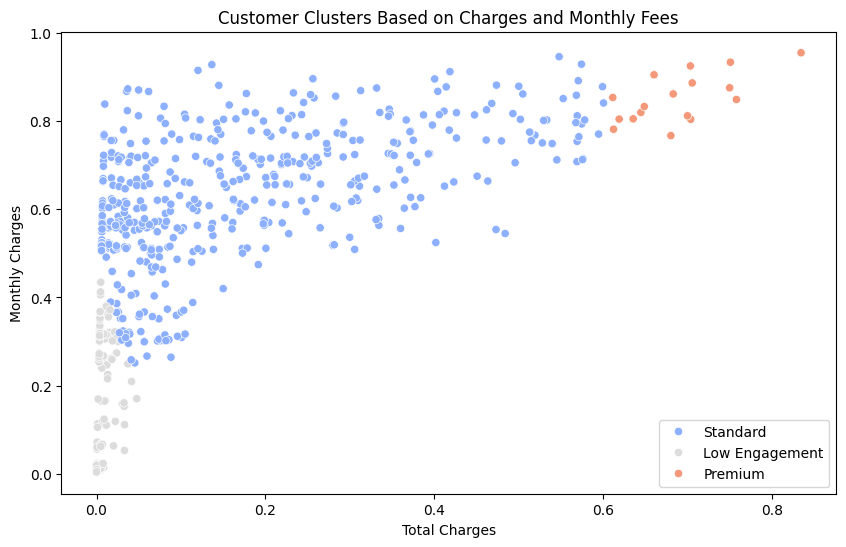

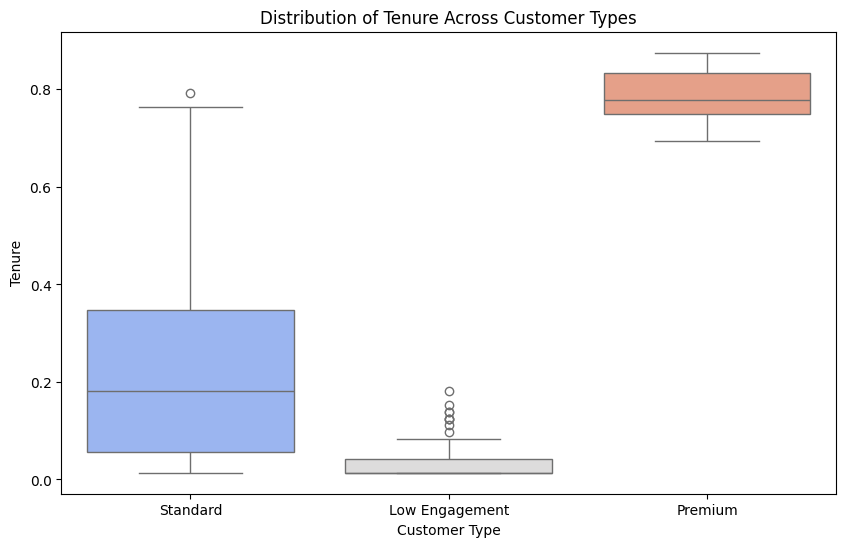

In [49]:
# Count the number of observations in each cluster
cluster_counts = filtered_df['customer_type'].value_counts()
print(f"Cluster Distribution:\n{cluster_counts}")

# Visualizing Clusters
plt.figure(figsize=(10,6))
sns.scatterplot(data=filtered_df, x='total_charges', y='monthly_charges', hue='customer_type', palette='coolwarm')
plt.title('Customer Clusters Based on Charges and Monthly Fees')
plt.xlabel('Total Charges')
plt.ylabel('Monthly Charges')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=filtered_df, x='customer_type', y='tenure', palette='coolwarm')
plt.title('Distribution of Tenure Across Customer Types')
plt.xlabel('Customer Type')
plt.ylabel('Tenure')
plt.show()

# Save the filtered dataframe as a CSV file inside the churn_data folder
filtered_df.to_csv('churn_data/churn_filter.csv', index=False)

In [50]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 631 entries, 1 to 1399
Data columns (total 15 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Unnamed: 0                              631 non-null    int64  
 1   customer_id                             631 non-null    object 
 2   total_charges                           631 non-null    float64
 3   tenure                                  631 non-null    float64
 4   payment_method_Electronic check         631 non-null    float64
 5   monthly_charges                         631 non-null    float64
 6   contract_Two year                       631 non-null    float64
 7   internet_service_Fiber optic            631 non-null    float64
 8   internet_service_No                     631 non-null    float64
 9   payment_method_Credit card (automatic)  631 non-null    float64
 10  dependents                              631 non-null    int64  
 1

In [51]:
# Assuming 'filtered_df' contains the relevant data with 'Cluster_Name'

# 1. Standard Customers (Cluster_Name == 'Standard Customers')
standard_customers_df = filtered_df[filtered_df['customer_type'] == 'Standard']

# 2. Low Engagement Customers (Cluster_Name == 'Low Engagement Customers')
low_engagement_customers_df = filtered_df[filtered_df['customer_type'] == 'Low Engagement']

# 3. Premium Customers (Cluster_Name == 'Premium Customers')
premium_customers_df = filtered_df[filtered_df['customer_type'] == 'Premium']

# Display the number of records in each DataFrame to verify
print(f"Standard Customers: {len(standard_customers_df)}")
print(f"Low Engagement Customers: {len(low_engagement_customers_df)}")
print(f"Premium Customers: {len(premium_customers_df)}")


Standard Customers: 478
Low Engagement Customers: 136
Premium Customers: 17


## 5.2 Optimisation

In [52]:
# Importing required libraries
import pickle  # For serializing and deserializing Python objects to/from files
import pandas as pd  # For data manipulation and analysis (DataFrames)
import numpy as np  # For numerical computing (arrays, matrices, etc.)
import random  # For generating random numbers
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, PULP_CBC_CMD  # For linear programming optimization
import os  # For interacting with the operating system (e.g., file paths, directories)
import json  # For working with JSON data (serialization/deserialization)
import matplotlib.pyplot as plt  # For plotting and visualizing data
import seaborn as sns # For plotting and visualizing data

In [53]:
# Load the saved scaler (MinMaxScaler in this case)
scaler_filename = "scaler_minmax.pkl"
with open(scaler_filename, 'rb') as f:
    scaler = pickle.load(f)

# Select the numerical features you want to inverse transform
num_features = ['tenure', 'total_charges', 'monthly_charges']

# Ensure the DataFrame (filtered_df) contains the scaled numerical features
# Apply the inverse transformation to scale the numerical features back to their original values
filtered_df[num_features] = scaler.inverse_transform(filtered_df[num_features])

# Display the output to confirm the reverse scaling
print("\n✅ Reverse Scaling Completed!")
print(filtered_df.head())  # Display the first few rows of the dataframe to check



✅ Reverse Scaling Completed!
   Unnamed: 0 customer_id  total_charges  tenure  \
1           1  2754-SDJRD         908.55     8.0   
3           3  0365-GXEZS        1468.75    18.0   
5           5  4686-UXDML        1992.55    21.0   
6           6  2227-JRSJX        1956.40    21.0   
9           9  4690-LLKUA         770.60    17.0   

   payment_method_Electronic check  monthly_charges  contract_Two year  \
1                              0.0           100.15                0.0   
3                              1.0            78.20                0.0   
5                              0.0            99.85                0.0   
6                              0.0            99.15                0.0   
9                              1.0            45.05                0.0   

   internet_service_Fiber optic  internet_service_No  \
1                           1.0                  0.0   
3                           1.0                  0.0   
5                           1.0             

In [54]:
# Display the first few rows to inspect the DataFrame
filtered_df.head()

,Unnamed: 0,customer_id,total_charges,tenure,payment_method_Electronic check,monthly_charges,contract_Two year,internet_service_Fiber optic,internet_service_No,payment_method_Credit card (automatic),dependents,contract_One year,y_pred,Class_1_Probability,customer_type
1,1,2754-SDJRD,908.55,8.0,0.0,100.15,0.0,1.0,0.0,1.0,0,0.0,1,0.948477,Standard
3,3,0365-GXEZS,1468.75,18.0,1.0,78.20,0.0,1.0,0.0,0.0,0,0.0,1,0.938257,Standard
5,5,4686-UXDML,1992.55,21.0,0.0,99.85,0.0,1.0,0.0,1.0,0,0.0,1,0.945967,Standard
6,6,2227-JRSJX,1956.40,21.0,0.0,99.15,0.0,1.0,0.0,0.0,0,0.0,1,0.961322,Standard
9,9,4690-LLKUA,770.60,17.0,1.0,45.05,0.0,0.0,0.0,0.0,0,0.0,1,0.564950,Standard


In [57]:
# Set fixed seed for reproducibility
random.seed(42)
np.random.seed(42)

# Load the filtered customer data (Assuming filtered_df contains the required customer data)
N = len(filtered_df)  # Number of customers

# **Define Budget Constraint**
budget = 15000  # Total available budget for interventions

# Extract initial churn probabilities from the DataFrame
initial_churn_prob = filtered_df['Class_1_Probability'].values

# **Sort Customers by Priority**
# Define priority order: Premium > Standard > Low Engagement
priority_order = {'Premium': 1, 'Standard': 2, 'Low Engagement': 3}
filtered_df['priority'] = filtered_df['customer_type'].map(priority_order)
filtered_df = filtered_df.sort_values(['priority', 'Class_1_Probability'], ascending=[True, False])

# **Intervention Cost Calculation and Adjustment**
# Calculate the intervention cost as a weighted sum of total and monthly charges
tot_dis = 0.10  # Discount for total charges
mon_dis = 0.10  # Discount for monthly charges
intervention_cost = (tot_dis * filtered_df["total_charges"] + mon_dis * filtered_df["monthly_charges"]).values


# Reduce intervention costs by 30% if the minimum cost is greater than the budget
if intervention_cost.min() > budget:
    intervention_cost *= 0.7

# **Define Decision Variables**
# x[i] = 1 if customer i is selected for intervention, 0 otherwise
x = [LpVariable(f"x_{i}", cat="Integer", lowBound=0, upBound=1) for i in range(N)]

# y[i] = 1 if customer i's churn is reduced below 0.3, 0 otherwise
y = [LpVariable(f"y_{i}", cat="Binary") for i in range(N)]

# churn_reduction_var[i] = amount by which customer i's churn probability is reduced
churn_reduction_var = [LpVariable(f"churn_reduction_{i}", lowBound=0, cat="Continuous") for i in range(N)]

# **Define the Optimization Problem**
prob = LpProblem("Churn_Reduction_Optimization", LpMaximize)

# **Objective Function**
# Maximize the total number of customers with churn probability below 0.3
prob += lpSum(y[i] for i in range(N))

# **Constraints**
# 1. Total intervention cost must not exceed the budget
prob += lpSum(intervention_cost[i] * x[i] for i in range(N)) <= budget

# 2. Churn reduction for each customer should not exceed their initial churn probability
for i in range(N):
    prob += churn_reduction_var[i] <= initial_churn_prob[i]

# 3. Ensure that a customer's churn probability is below 0.3 if selected
for i in range(N):
    prob += initial_churn_prob[i] - churn_reduction_var[i] <= 0.3 + (1 - y[i]) * 1000

# 4. If a customer is selected for intervention, their churn must be reduced below 0.3
for i in range(N):
    prob += x[i] <= y[i]

# 5. A customer can only be selected for intervention if their churn is reduced to below 0.3
for i in range(N):
    prob += y[i] <= x[i]

# **Prioritize Premium Customers**
# Enforce that higher priority customers are selected before lower priority ones
for i in range(N):
    for j in range(i + 1, N):
        if filtered_df['priority'].iloc[i] < filtered_df['priority'].iloc[j]:
            prob += x[i] >= x[j]

# **Solve the Optimization Problem**
prob.solve(PULP_CBC_CMD(msg=False, warmStart=True))

# **Extract Results**
# Get the selected customers based on the optimization results
selected_customers = [i for i in range(N) if x[i].value() == 1]

# Calculate total costs and churn reduction for selected customers
total_cost = sum(intervention_cost[i] for i in selected_customers)
total_churn_after = sum((initial_churn_prob[i] - churn_reduction_var[i].value()) for i in selected_customers)

# Calculate new churn probability for each customer after intervention
new_churn_prob = [initial_churn_prob[i] - churn_reduction_var[i].value() for i in range(N)]

# **Create Result DataFrame for Visualization**
result_df = pd.DataFrame({
    "customer_id": filtered_df['customer_id'],
    "Initial_Churn_Prob": initial_churn_prob,
    "Intervention_Cost": intervention_cost,
    "Churn_Reduction": [churn_reduction_var[i].value() for i in range(N)],
    "Selected": [int(x[i].value()) for i in range(N)],
    "Churn_Below_0.3": [int(y[i].value()) for i in range(N)],
    "New_Churn_Prob": new_churn_prob  # Add new churn probability
})

# **Debugging Information**
print(f"🔍 Total Customers in Dataset: {N}")
print(f"🔍 Min Intervention Cost: ${intervention_cost.min():.2f}")
print(f"🔍 Max Intervention Cost: ${intervention_cost.max():.2f}")
print(f"🔍 Customers Selected for Intervention: {len(selected_customers)}")
print(f"🔍 Total Budget Used: ${total_cost:.2f}")

# **Optimization Summary**
print(f"\n✅ Optimization Completed!")
print(f"🔹 Total Churn Probability Reduction: {total_churn_after:.2f}")


🔍 Total Customers in Dataset: 631
🔍 Min Intervention Cost: $3.77
🔍 Max Intervention Cost: $724.62
🔍 Customers Selected for Intervention: 176
🔍 Total Budget Used: $14946.40

✅ Optimization Completed!
🔹 Total Churn Probability Reduction: 52.80


In [58]:
# Display the first few rows to inspect the DataFrame
result_df.head()

,customer_id,Initial_Churn_Prob,Intervention_Cost,Churn_Reduction,Selected,Churn_Below_0.3,New_Churn_Prob
1010,9278-VZKCD,0.882617,575.705,0.582617,1,1,0.3
950,7056-IMHCC,0.871719,565.130,0.571719,1,1,0.3
147,0486-HECZI,0.844601,533.565,0.544601,1,1,0.3
236,9079-YEXQJ,0.840360,612.595,0.540360,1,1,0.3
1220,4840-ORQXB,0.816209,594.610,0.516209,1,1,0.3


In [59]:
import os
import pandas as pd

# Assuming filtered_df and result_df are already defined and contain the necessary data

# Calculate intervention cost components separately
total_charges_cost = 0.10 * filtered_df["total_charges"]
monthly_charges_cost = 0.10 * filtered_df["monthly_charges"]

# Calculate the total intervention costs
intervention_cost_total = total_charges_cost
intervention_cost_monthly = monthly_charges_cost

# Apply the intervention cost to 'total_charges' for selected customers
filtered_df['total_charges_after_intervention'] = filtered_df['total_charges']
filtered_df.loc[result_df['Selected'] == 1, 'total_charges_after_intervention'] -= intervention_cost_total[result_df['Selected'] == 1]

# Apply the intervention cost to 'monthly_charges' for selected customers
filtered_df['monthly_charges_after_intervention'] = filtered_df['monthly_charges']
filtered_df.loc[result_df['Selected'] == 1, 'monthly_charges_after_intervention'] -= intervention_cost_monthly[result_df['Selected'] == 1]

# Create a new DataFrame with the updated columns
result_df_updated = pd.DataFrame({
    "customer_id": result_df['customer_id'],
    "total_charges": filtered_df['total_charges'],
    "total_charges_after_intervention": filtered_df['total_charges_after_intervention'],
    "monthly_charges": filtered_df['monthly_charges'],
    "monthly_charges_after_intervention": filtered_df['monthly_charges_after_intervention'],
    "intervention_cost": result_df['Intervention_Cost'],
    "customer_type": filtered_df['customer_type'],
    "New_Churn_Prob": result_df['New_Churn_Prob'],
    "Selected": result_df['Selected'],
    "Churn_Below_0.3": result_df['Churn_Below_0.3']
})

# Ensure the 'optimisation' folder exists
os.makedirs('optimisation', exist_ok=True)

# Define the file path for saving the DataFrame
file_path = os.path.join('optimisation', 'updated_discount_data.csv')

# Save the DataFrame to a CSV file
result_df_updated.to_csv(file_path, index=False)

# Print success message
print(f"✅ Data successfully saved to {file_path}")

✅ Data successfully saved to optimisation\updated_discount_data.csv


In [60]:
# Display the first few rows to inspect the DataFrame
result_df_updated.head()

,customer_id,total_charges,total_charges_after_intervention,monthly_charges,monthly_charges_after_intervention,intervention_cost,customer_type,New_Churn_Prob,Selected,Churn_Below_0.3
1010,9278-VZKCD,5647.95,5083.155,109.10,98.190,575.705,Premium,0.3,1,1
950,7056-IMHCC,5549.40,4994.460,101.90,91.710,565.130,Premium,0.3,1,1
147,0486-HECZI,5238.90,4715.010,96.75,87.075,533.565,Premium,0.3,1,1
236,9079-YEXQJ,6014.85,5413.365,111.10,99.990,612.595,Premium,0.3,1,1
1220,4840-ORQXB,5841.35,5257.215,104.75,94.275,594.610,Premium,0.3,1,1


In [62]:
# Assuming result_df_updated contains the following columns:
# customer_id, Selected, intervention_cost, monthly_charges_after_intervention, total_charges_after_intervention

# Define the customer_id for which you want to apply the logic
customer_id = '9278-VZKCD'

# Find the row corresponding to the customer_id
customer_row = result_df_updated[result_df_updated['customer_id'] == customer_id]

# Create the "optimisation" folder if it doesn't exist
os.makedirs('optimisation', exist_ok=True)

# Check if customer exists and handle both eligible and non-eligible cases
if not customer_row.empty:
    selected = customer_row['Selected'].iloc[0]
    
    if selected == 1:
        # Eligible for discount
        intervention_cost = customer_row['intervention_cost'].iloc[0]
        monthly_charges = customer_row['monthly_charges_after_intervention'].iloc[0]
        total_charges = customer_row['total_charges_after_intervention'].iloc[0]

        # Calculate the total discount
        total_discount = intervention_cost

        # Prepare the new values for monthly and total charges
        new_monthly_charges = monthly_charges
        new_total_charges = total_charges

        # Output the result for eligible customer
        print(f"Customer ID: {customer_id} is eligible for a discount.")
        print(f"Total discount: {total_discount}")
        print(f"New monthly charges after discount: {new_monthly_charges}")
        print(f"New total charges after discount: {new_total_charges}")

    else:
        # Non-eligible for discount
        total_discount = 0
        new_monthly_charges = customer_row['monthly_charges'].iloc[0]
        new_total_charges = customer_row['total_charges'].iloc[0]

        # Output the result for non-eligible customer with 2 decimal places
        print(f"Customer ID: {customer_id} is not eligible for a discount.")
        print(f"Total discount: {total_discount:.2f}")  # Format to 2 decimal places
        print(f"Monthly charges: {new_monthly_charges:.2f}")  # Format to 2 decimal places
        print(f"Total charges: {new_total_charges:.2f}")  # Format to 2 decimal places
        

    # Prepare the result as a dictionary and convert non-serializable pandas types to native Python types
    discount_info = {
        'customer_id': customer_id,
        'selected': int(selected),  # Convert to int
        'total_discount': round(float(total_discount), 2),  # Convert to float and round to 2 decimal places
        'new_monthly_charges': round(float(new_monthly_charges), 2),  # Convert to float and round to 2 decimal places
        'new_total_charges': round(float(new_total_charges), 2)  # Convert to float and round to 2 decimal places
    }

    # Define the file path for saving the JSON file
    json_file_path = os.path.join('optimisation', f'discount_{customer_id}.json')

    # Save the result to the JSON file
    with open(json_file_path, 'w') as json_file:
        json.dump(discount_info, json_file, indent=4)

    print(f"\n✅ Discount information saved successfully as {json_file_path}")

else:
    print(f"Customer ID: {customer_id} not found.")


Customer ID: 9278-VZKCD is eligible for a discount.
Total discount: 575.7049999999999
New monthly charges after discount: 98.18999999999998
New total charges after discount: 5083.155

✅ Discount information saved successfully as optimisation\discount_9278-VZKCD.json


In [63]:
# Filter result_df_updated to keep only rows where 'Selected' is 1
filtered_result_df = result_df_updated[result_df_updated['Selected'] == 1]
filtered_result_df
# Now, filtered_result_df will contain only the rows where Selected == 1


,customer_id,total_charges,total_charges_after_intervention,monthly_charges,monthly_charges_after_intervention,intervention_cost,customer_type,New_Churn_Prob,Selected,Churn_Below_0.3
1010,9278-VZKCD,5647.95,5083.155,109.10,98.190,575.705,Premium,0.3,1,1
950,7056-IMHCC,5549.40,4994.460,101.90,91.710,565.130,Premium,0.3,1,1
147,0486-HECZI,5238.90,4715.010,96.75,87.075,533.565,Premium,0.3,1,1
236,9079-YEXQJ,6014.85,5413.365,111.10,99.990,612.595,Premium,0.3,1,1
1220,4840-ORQXB,5841.35,5257.215,104.75,94.275,594.610,Premium,0.3,1,1
...,...,...,...,...,...,...,...,...,...,...
1360,8985-OOPOS,74.10,66.690,74.10,66.690,14.820,Standard,0.3,1,1
403,7629-WIXZF,369.25,332.325,59.10,53.190,42.835,Standard,0.3,1,1
1266,3948-FVVRP,452.80,407.520,54.80,49.320,50.760,Standard,0.3,1,1
1246,2720-FVBQP,273.25,245.925,48.95,44.055,32.220,Standard,0.3,1,1


In [64]:
# Group by 'customer_type' and 'Selected' to analyze total intervention cost
analysis_df = result_df_updated.groupby(['customer_type', 'Selected']).agg(
    total_intervention_cost=pd.NamedAgg(column='intervention_cost', aggfunc='sum'),
    average_intervention_cost=pd.NamedAgg(column='intervention_cost', aggfunc='mean'),
    total_customers=pd.NamedAgg(column='customer_id', aggfunc='count')
).reset_index()

In [65]:
analysis_df

,customer_type,Selected,total_intervention_cost,average_intervention_cost,total_customers
0,Low Engagement,0,1579.800,11.616176,136
1,Premium,1,10183.115,599.006765,17
2,Standard,0,67742.070,212.357586,319
3,Standard,1,4763.290,29.957799,159


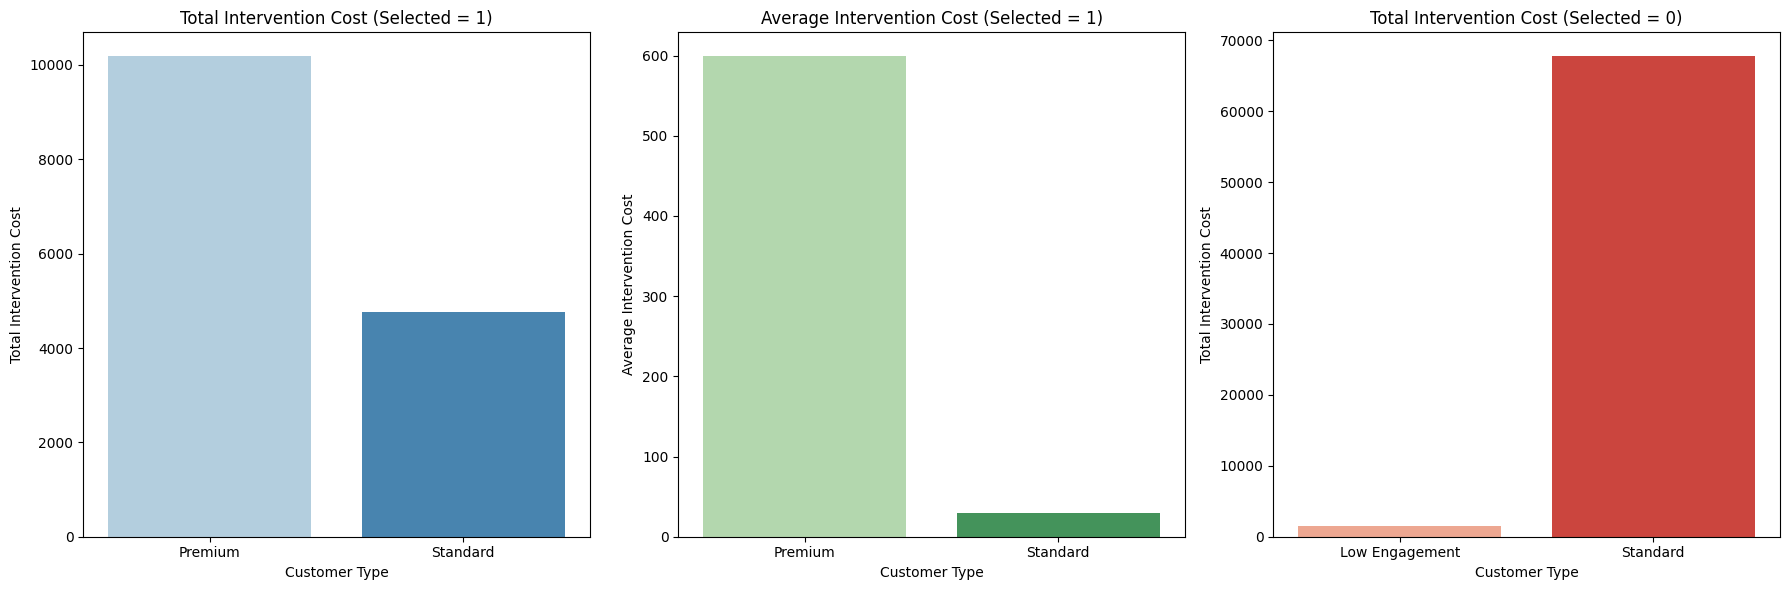

In [66]:
# Assuming analysis_df is already defined

# Plot 1: Selected = 1
selected_1_df = analysis_df[analysis_df['Selected'] == 1]

# Create a figure and set of subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Total Intervention Cost for Selected = 1
sns.barplot(x='customer_type', y='total_intervention_cost', data=selected_1_df, ax=axes[0], palette='Blues')
axes[0].set_title('Total Intervention Cost (Selected = 1)')
axes[0].set_ylabel('Total Intervention Cost')
axes[0].set_xlabel('Customer Type')

# Plot Average Intervention Cost for Selected = 1
sns.barplot(x='customer_type', y='average_intervention_cost', data=selected_1_df, ax=axes[1], palette='Greens')
axes[1].set_title('Average Intervention Cost (Selected = 1)')
axes[1].set_ylabel('Average Intervention Cost')
axes[1].set_xlabel('Customer Type')

# Plot the total intervention cost for all customers
# Plot 2: Selected = 0
selected_0_df = analysis_df[analysis_df['Selected'] == 0]

# Plot Total Intervention Cost for Selected = 0
sns.barplot(x='customer_type', y='total_intervention_cost', data=selected_0_df, ax=axes[2], palette='Reds')
axes[2].set_title('Total Intervention Cost (Selected = 0)')
axes[2].set_ylabel('Total Intervention Cost')
axes[2].set_xlabel('Customer Type')

# Adjust layout and display plots
plt.tight_layout()

# Show the plots
plt.show()


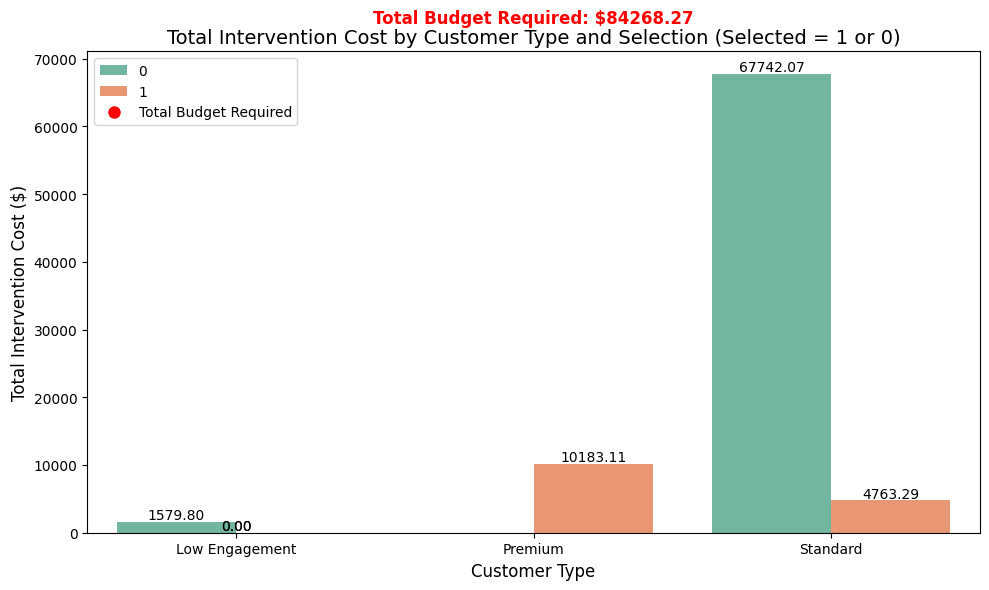

In [67]:
# Assuming analysis_df is already defined

# Calculate the total intervention cost (sum of total intervention costs across all categories)
total_budget_required = analysis_df['total_intervention_cost'].sum()

# Create a figure and set of subplots for Total Intervention Cost by Selected and Customer Type
fig, axes = plt.subplots(1, 1, figsize=(10, 6))

# Plot Total Intervention Cost for both Selected = 1 and Selected = 0
sns.barplot(x='customer_type', y='total_intervention_cost', hue='Selected', data=analysis_df, ax=axes, palette='Set2')

# Add values on top of the bars
for p in axes.patches:
    height = p.get_height()
    axes.annotate(f'{height:.2f}', 
                  (p.get_x() + p.get_width() / 2., height), 
                  ha='center', va='center', 
                  fontsize=10, color='black', 
                  xytext=(0, 5), textcoords='offset points')

# Add the total budget required as a separate annotation at the top of the plot
axes.text(0.5, 1.05, f'Total Budget Required: ${total_budget_required:.2f}', 
          ha='center', va='bottom', fontsize=12, fontweight='bold', color='red', transform=axes.transAxes)

# Set titles and labels
axes.set_title('Total Intervention Cost by Customer Type and Selection (Selected = 1 or 0)', fontsize=14)
axes.set_xlabel('Customer Type', fontsize=12)
axes.set_ylabel('Total Intervention Cost ($)', fontsize=12)

# Add a custom legend for the total budget required
handles, labels = axes.get_legend_handles_labels()
axes.legend(handles=handles + [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10)], 
            labels=labels + ['Total Budget Required'], loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()